Author: Alexis Laignelet \\
Date: 5th June 2020

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.stats as stats
import pandas as pd
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from abc import ABC, abstractmethod 

In [0]:
def bernoulli_reward(mean):
  return stats.bernoulli(mean)

def normal_reward(mean):
  return stats.norm(loc=mean, scale=1.)

def normal_mean():
  return stats.norm(loc=0, scale=1.)

def uniform_mean():
  return stats.uniform(loc=0, scale=1.)

In [0]:
class Bandit:
  def __init__(self, k, mean_distribution, reward_distribution, policy):
    self.k = k
    self.arm_means = mean_distribution().rvs(k)
    self.arm_reward_distributions = [reward_distribution(mean) for mean in self.arm_means]
    self.arm_trial_counts = np.zeros(k)
    self.policy = policy

  def get_reward(self, chosen_arm):
    reward = self.arm_reward_distributions[chosen_arm].rvs()
    return reward

  def run_experiment(self):
    chosen_arm = self.policy.choose_arm()
    reward = self.get_reward(chosen_arm)
    self.policy.update_policy(chosen_arm, reward)
    return reward

In [0]:
class Policy(ABC):
  @abstractmethod
  def choose_arm(self):
    pass

  @abstractmethod
  def update_policy(self, chosen_arm, reward):
    pass

In [0]:
class GreedyPolicy(Policy):
  def __init__(self, epsilon, k):
    self.k = k
    self.epsilon = epsilon
    self.arm_estimated_means = np.zeros(self.k)
    self.arm_trial_counts = np.zeros(self.k)

  def choose_arm(self): 
    if self.epsilon > np.random.uniform(0, 1): 
        chosen_arm = np.random.randint(self.k)
    else:
        chosen_arm = np.argmax(self.arm_estimated_means)
    return chosen_arm   

  def update_policy(self, chosen_arm, reward):
    self.arm_trial_counts[chosen_arm] += 1 
    alpha = 1./self.arm_trial_counts[chosen_arm]
    self.arm_estimated_means[chosen_arm] += alpha * (reward - self.arm_estimated_means[chosen_arm])

In [0]:
class UBCPolicy(Policy):
  def __init__(self, k):
    self.k = k
    self.arm_radiuses = np.zeros(k)
    self.arm_estimated_means = np.zeros(self.k)
    self.arm_trial_counts = np.zeros(self.k)

  def choose_arm(self):
    return np.argmax(self.arm_estimated_means + self.arm_radiuses)

  def update_policy(self, chosen_arm, reward):
    self.arm_trial_counts[chosen_arm] += 1 
    self.arm_radiuses = np.sqrt(2 * np.log(1 + self.arm_trial_counts.sum()) / (1 + self.arm_trial_counts))
    alpha = 1./self.arm_trial_counts[chosen_arm]
    self.arm_estimated_means[chosen_arm] += alpha * (reward - self.arm_estimated_means[chosen_arm])

In [0]:
class ThompsonPolicy(Policy):
  def __init__(self, k):
    self.k = k
    self.arm_trial_counts = np.zeros(self.k)
    self.arm_success_counts = np.zeros(self.k) 
    self.arm_prior_distributions = [stats.beta(a=1, b=1) for i in range(self.k)]
  
  def choose_arm(self):
    theta_samples = np.array([distribution.rvs(1).item() for distribution in self.arm_prior_distributions])
    return np.argmax(theta_samples)

  def update_policy(self, chosen_arm, reward):
    self.arm_trial_counts[chosen_arm] += 1
    self.arm_success_counts[chosen_arm] += reward
    posterior_distributions = [stats.beta(a=1+success_count, b=1+trial_count-success_count)
                               for trial_count, success_count in zip(self.arm_trial_counts, self.arm_success_counts)]
    self.arm_prior_distributions = posterior_distributions

# Example 1 - Stochastic bandits

Let k arms with rewards following a Gaussian distribution $\mathcal{N}(\mu_i, 1)$. For simplicity the means $\mu_i$ are generated from a uniform distribution $\mathcal{U}[0, 1]$.

Two policies are implemented:


*   $\epsilon$-greedy,
*   Upper Confidence Bound.


The estimated mean is computed this way:
\begin{align*}
  \mathbb{E}[\mu_a] \leftarrow  \mathbb{E}[\mu_a] + \alpha \left(R_{a, t} - \mathbb{E}[\mu_a] \right)
\end{align*}

Usually $\alpha = \frac{1}{T_a}$ but you can 'forget' faster by taking higher values for $\alpha$. Eg $\alpha = 0.1$. 


In [0]:
def multi_experiments(bandit, experiences):
  max_mean = max(bandit.arm_means)
  rewards = np.zeros(experiences) 
  regrets = np.zeros(experiences+1)
  
  for it in range(experiences):
    reward = bandit.run_experiment()
    rewards[it] = reward
    regrets[it+1] = regrets[it] + max_mean - reward

  return rewards, regrets[1:]

In [0]:
def average_results(k, mean_distribution, reward_distribution, experiences, n_average, epsilon=None):
  average_rewards = np.zeros(experiences)
  average_regrets = np.zeros(experiences)

  for i in tqdm(range(n_average)):
    if epsilon != None:
      policy = GreedyPolicy(epsilon=epsilon, k=k)
    else:
      policy = UBCPolicy(k)
    bandit = Bandit(k=k, mean_distribution=mean_distribution, reward_distribution=reward_distribution, policy=policy)
    new_rewards, new_regrets = multi_experiments(bandit, experiences)
    average_rewards += new_rewards
    average_regrets += new_regrets 

  average_rewards /= n_average 
  average_regrets /= n_average
  return average_rewards, average_regrets

In [0]:
k = 10
epsilon = 0.01
mean_distribution = normal_mean
reward_distribution = normal_reward
experiences = 1000
n_average = 200

In [0]:
average_rewards_greedy, average_regrets_greedy = average_results(k, mean_distribution, reward_distribution, experiences, n_average, epsilon=epsilon)
average_rewards_ucb, average_regrets_ucb = average_results(k, mean_distribution, reward_distribution, experiences, n_average)

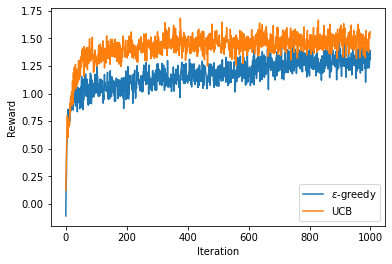

In [0]:
plt.plot(average_rewards_greedy, label='$\epsilon$-greedy')
plt.plot(average_rewards_ucb, label='UCB')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend();

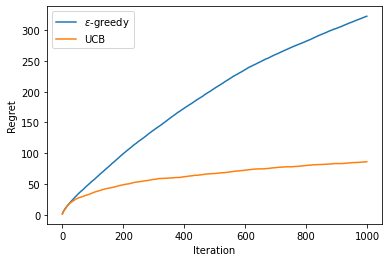

In [0]:
plt.plot(average_regrets_greedy, label='$\epsilon$-greedy')
plt.plot(average_regrets_ucb, label='UCB')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.legend();

# Example 2 - Bernoulli bandits

In this setup, the likelihood $p(x | \theta)$ follows a Bernoulli. A natural choice for the prior is the Beta distribution since it is a conjugate prior with the Bernoulli distribution. In this context, the posterior is also a Beta distribution that evolves according to: if $x$ is a win, the posterior becomes $Beta(\alpha +1, \beta)$, and if it is a fail, it becomes $Beta(\alpha, \beta +1)$.


In [0]:
def plot_thompson_priors(policy, ax, experience):
  x = np.linspace(0.001, 0.999, 100)
  for arm_prior_distribution in policy.arm_prior_distributions:
      y = arm_prior_distribution.pdf(x)
      ax.plot(x, y)
      ax.fill_between(x, y, 0, alpha=0.2)
  ax.set_xlabel('x')
  ax.set_ylabel('Prior')
  ax.set_title('t = ' + str(experience))

In [0]:
k = 3
mean_distribution = uniform_mean
reward_distribution = bernoulli_reward
experiences = 50
indexes = [int(ratio * (experiences-1)) for ratio in [0.25, 0.5, 0.75, 1.]]

In [0]:
policy = ThompsonPolicy(k)
bandit = Bandit(k=k, mean_distribution=mean_distribution, reward_distribution=reward_distribution, policy=policy)

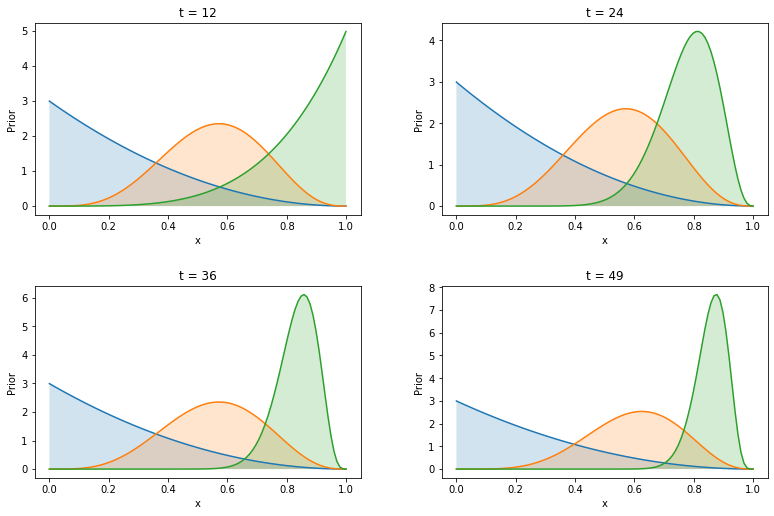

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()
fig.tight_layout(pad=5.0)
for experience in range(experiences):
  bandit.run_experiment()
  if experience in indexes:
    policy = bandit.policy
    plot_thompson_priors(policy=policy, ax=axs[indexes.index(experience)], experience=experience)

# Example 3 - Contextual bandits

In this setup, the context influences the probabilities of the Bernoulli law of the arms. For convenience, we chose to model this effect by defining then as the result of a logistic regression over the context, where the parameters are unkown for the learner.
\begin{align*}
  p_k(x) = \frac{1}{1 + e^{- a_k x - \epsilon}}
\end{align*}

with $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

Again, for convenience, the context is only model by a unique variable $x$, and the logistic regression only has one parameter.

In [0]:
def sine_context(time):
  return np.sin(0.1 * time)

In [0]:
def sigmoid_mean(arm_parameter, context):
  return expit(arm_parameter * context)

In [0]:
def lognormal_parameter():
  return stats.lognorm(s=1)

In [0]:
class ContextualBandit(Bandit):
  def __init__(self, k, parameter_distribution, mean_construction, reward_distribution, policy, context):
    self.k = k
    self.context = context
    self.arm_parameters = parameter_distribution().rvs(k)
    self.arm_means = [mean_construction(arm_parameter, self.context(0)) for arm_parameter in self.arm_parameters]
    self.arm_reward_distributions = [reward_distribution(mean) for mean in self.arm_means]
    self.time = 0
    self.policy = policy

  def get_reward(self, chosen_arm):
    self.arm_means = [mean_construction(arm_parameter, self.context(self.time)) for arm_parameter in self.arm_parameters]
    self.arm_reward_distributions = [reward_distribution(mean) for mean in self.arm_means]
    reward = self.arm_reward_distributions[chosen_arm].rvs()
    return reward

  def run_experiment(self):
    chosen_arm = self.policy.choose_arm()
    reward = self.get_reward(chosen_arm)
    self.policy.update_policy(chosen_arm, reward)
    self.time += 1

In [0]:
class ContextGreedyPolicy(Policy):
  def __init__(self, epsilon, k, context):
    self.k = k
    self.context = context
    self.epsilon = epsilon
    self.arm_estimated_means = np.zeros(self.k)
    self.time = 0
    self.history = []

  def choose_arm(self):
    df = pd.DataFrame(self.history, columns=['x', 'k', 'reward'])
    if df.groupby(['k', 'reward']).size().shape[0] == 2 * self.k:
      if self.epsilon > np.random.uniform(0, 1): 
        chosen_arm = np.random.randint(self.k)
      else:
        chosen_arm = np.argmax(self.arm_estimated_means)
    else:
      chosen_arm = np.random.randint(self.k)
    return chosen_arm 

  def update_policy(self, chosen_arm, reward):
    update = {}
    update['x'] = self.context(self.time)
    update['k'] = chosen_arm
    update['reward'] = reward
    self.history.append(update)

    df = pd.DataFrame(self.history, columns=['x', 'k', 'reward'])

    if df.groupby(['k', 'reward']).size().shape[0] == 2 * self.k:
      for i in range(self.k):
        data = df[df['k'] == i]
        X = data['x']
        y = data['reward']
        lr = LogisticRegression(fit_intercept=False).fit(X.values.reshape(-1, 1), y)
        current_x = self.context(self.time)
        self.arm_estimated_means[i] = lr.predict_proba(np.array(current_x).reshape(-1, 1))[0][1]

    self.time += 1

In [0]:
def plot_mean(bandit):
  x = np.linspace(-5, 5, 200)
  for i, value in enumerate(bandit.arm_parameters):
    plt.plot(x, expit(value * x), label='arm ' + str(i))
  plt.xlabel('Context x')
  plt.ylabel('Mean reward')
  plt.legend()

In [0]:
k = 2
epsilon = 0.1
parameter_distribution = lognormal_parameter
mean_construction = sigmoid_mean
reward_distribution = bernoulli_reward
context = sine_context
policy = ContextGreedyPolicy(epsilon=epsilon, k=k, context=context)
experiences = 100

In [0]:
cbandit = ContextualBandit(k=k, parameter_distribution=parameter_distribution, mean_construction=mean_construction,
                           reward_distribution=reward_distribution, policy=policy, context=context)

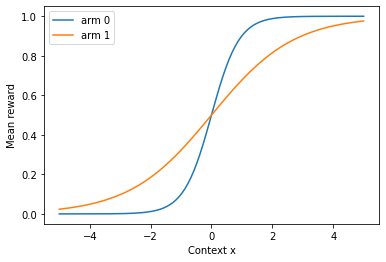

In [26]:
plot_mean(cbandit)

In [0]:
for experience in range(experiences):
  cbandit.run_experiment()

In [0]:
data = pd.DataFrame(cbandit.policy.history)
data0 = data[data['k'] == 0]
data1 = data[data['k'] == 1]

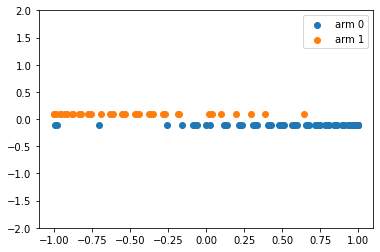

In [29]:
plt.scatter(data0['x'], np.zeros_like(data0['x']) -.1, label='arm 0')
plt.scatter(data1['x'], np.zeros_like(data1['x']) + .1, label='arm 1')
plt.ylim(-2, 2)
plt.legend();

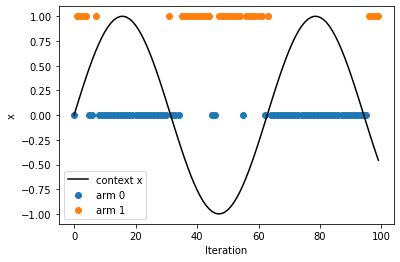

In [30]:
plt.plot(data['x'], color='black', label='context x')
plt.scatter(data0.index, data0['k'], label='arm 0')
plt.scatter(data1.index, data1['k'], label='arm 1')
plt.xlabel('Iteration')
plt.ylabel('x')
plt.legend();